# Phase 1 Collection (11/04/2023 - 31/05/2023)

During phase 1 collection, 2 NDIR CO2 sensors (model: Sensiron SCD30) were used to sense the CO2 levels within the glass container. Both sensor modules are equipped with temperature and humidity sensors that allows them to quantify exactly how hot and humid the inside of the container is.

## Data Analysis

The data collected from this has several observed patterns:

1. **Daily:** Temperatures will rise accordingly based on how sunny that day is. The highest temperature reached on any given day is ___. The temperature required for decomposition of PolyTerra PLA is stated by the manufacturer to be ___. 
2. **Daily:** Humidity will be lowered in reverse proportion to the temperature, as the water ___ (does the water condensate off?). 
3. **Overall Trend:** There was no observed increase in CO2 throughout the experimentation period

Weight analysis: \<To be done\>

\<Add photos here of the probably decomposed plastics?\>

As such, we conclude that during phase 1, \<conclusion here\> PLA decomposition did/did not occur within the glass envelope.

## Process 1: ingestion of data

This process phase ingests and cleans multiple CSV files as data into a pandas array

In [723]:
import pandas as pd
from pandas.core.api import DataFrame
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import numpy as np
# import ipywidgets as widgets
# from ipywidgets import interact, interact_manual

In [724]:
# ingest data
co2_directory = 'CO2'
li_co2 = []

for filename in os.listdir(co2_directory):
    f = os.path.join(co2_directory, filename)
    # checking if it is a file
    if os.path.isfile(f) and filename[-3:] == 'csv':
        li_co2.append(pd.read_csv(f, parse_dates=[3], encoding='utf-8'))

frame_co2 = pd.concat(li_co2, axis=0, ignore_index=True)

hum_directory = 'Humidity'
li_hum = []

for filename in os.listdir(hum_directory):
    f = os.path.join(hum_directory, filename)
    # checking if it is a file
    if os.path.isfile(f) and filename[-3:] == 'csv':
        li_hum.append(pd.read_csv(f, parse_dates=[3], encoding='utf-8'))

frame_hum = pd.concat(li_hum, axis=0, ignore_index=True)

temp_directory = 'Temperature'
li_temp = []

for filename in os.listdir(temp_directory):
    f = os.path.join(temp_directory, filename)
    # checking if it is a file
    if os.path.isfile(f) and filename[-3:] == 'csv':
        li_temp.append(pd.read_csv(f, parse_dates=[3], encoding='utf-8'))

frame_temp = pd.concat(li_temp, axis=0, ignore_index=True)

# clean data (strip metadata)
frame_co2 = frame_co2.drop(columns=['id', 'feed_id', 'lat', 'lon', 'ele'])
frame_hum = frame_hum.drop(columns=['id', 'feed_id', 'lat', 'lon', 'ele'])
frame_temp = frame_temp.drop(columns=['id', 'feed_id', 'lat', 'lon', 'ele'])

# localize the timezones
frame_co2['created_at'] = frame_co2['created_at'].dt.tz_convert('Asia/Singapore')
frame_hum['created_at'] = frame_hum['created_at'].dt.tz_convert('Asia/Singapore')
frame_temp['created_at'] = frame_temp['created_at'].dt.tz_convert('Asia/Singapore')

# make the datetime the index and dedupe the overlapping times
frame_co2 = frame_co2.set_index('created_at').drop_duplicates()
frame_hum = frame_hum.set_index('created_at').drop_duplicates()
frame_temp = frame_temp.set_index('created_at').drop_duplicates()


## Process 2: datetime processing

The dates and times have to be processed to be normalized, 5 minute intervals in order to facilitate data correlation between the 3 types of data. This resultant data can be pickled and cached on disk for rapid re-computation when tweaking the visualization algos.

The data has to be cleaned and then processed as follows:

1. Remove some of the rows with invalid data streams (e.g. at the start where only temperature is recorded)
2. Drop invalid NaN data points
3. Merge all data based on a time tolerance
4. Combine the data back into a single dataframe

In [725]:
# combine all into one big dataframe
frame_co2 = frame_co2.rename(columns = {'value':'co2'})
frame_temp = frame_temp.rename(columns = {'value':'temp'})
frame_hum = frame_hum.rename(columns = {'value':'hum'})

frame_final = pd.merge(frame_co2, frame_hum, how='outer', on='created_at', validate='1:1')
frame_final = pd.merge(frame_final, frame_temp, how='outer', on='created_at', validate='1:1')
frame_final = frame_final.sort_index().reset_index()

# i think checking if the next datum is within the same minute of the first datum is enough to consider those data a singular reading

# cache a local copy of the index and hold it
# base_index = 0

# for idx, row in frame_final.iterrows():
#     if base_index == 0:
#         base_index = idx
#         # print(base_index)
#     base_index = 0

# a vectorized version could be to take diffs of one entry to its previous entry, tag it and combine it based on tagging
frame_final['group_with'] = frame_final['created_at'].diff() < pd.Timedelta(seconds=10)
# frame_final.to_csv('debug.csv') # this is just for debug to see what the data looks like rn

# for row in frame_final.itertuples():
#     # check if row already has all data, sometimes this does happen where one row has 2 or even 3 parameters already in
#     print(row)

In [726]:
# Removes the initial rows where only temperature is being recorded, as well as the last few rows where the True/False falls apart
frame_final_cleaved = frame_final[501:35246]

# Split all individual parameter dataframes using the cleaved dataframe, drop any rows that have NaN
f2_co2 = frame_final_cleaved[['created_at', 'co2']].copy().dropna(axis=0, how='any')
f2_hum = frame_final_cleaved[['created_at', 'hum']].copy().dropna(axis=0, how='any')
f2_temp = frame_final_cleaved[['created_at', 'temp']].copy().dropna(axis=0, how='any')

# Use Pandas merge_asof which can set the tolerance based on a given parameter
# Use Timedelta with temperature as the basis ()
f2 = pd.merge_asof(f2_temp, f2_hum, on='created_at', tolerance=pd.Timedelta(seconds=10), direction='forward')
f2 = pd.merge_asof(f2, f2_co2, on='created_at', tolerance=pd.Timedelta(seconds=10), direction='forward')

frame_final = f2[['created_at', 'co2', 'hum', 'temp']]

# Uncomment below to show all data
# for row in frame_flattened.itertuples():
#     print(row)

## Process 3A: Visualisation 1, Long Term Trends

The long term CO2 trend as presented in this graph displays only a daily oscillating trend with no majorly discernable increase over the period of two months.

Towards the end of the graph, all long term trends show a drastic and abnormal spike possibly due to sensor error and should be disregarded. 

/opt/homebrew/Caskroom/miniconda/base/envs/cornmen/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/cornmen/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/cornmen/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.03, 'CO2 Long Term')

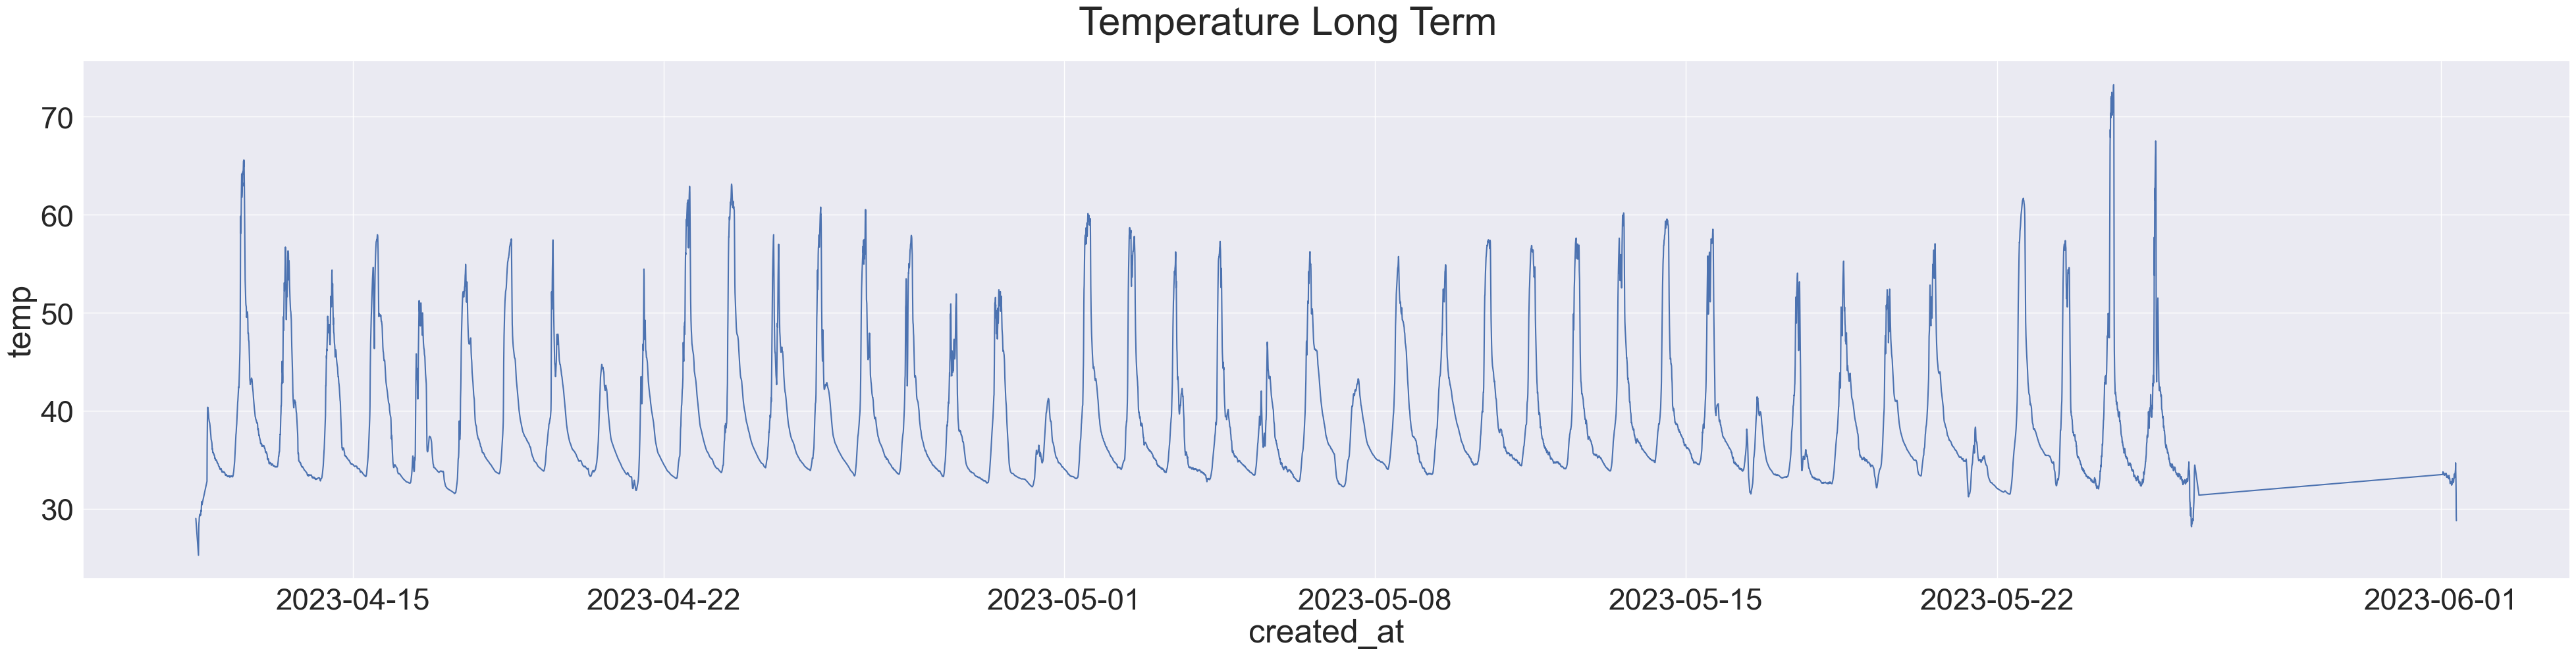

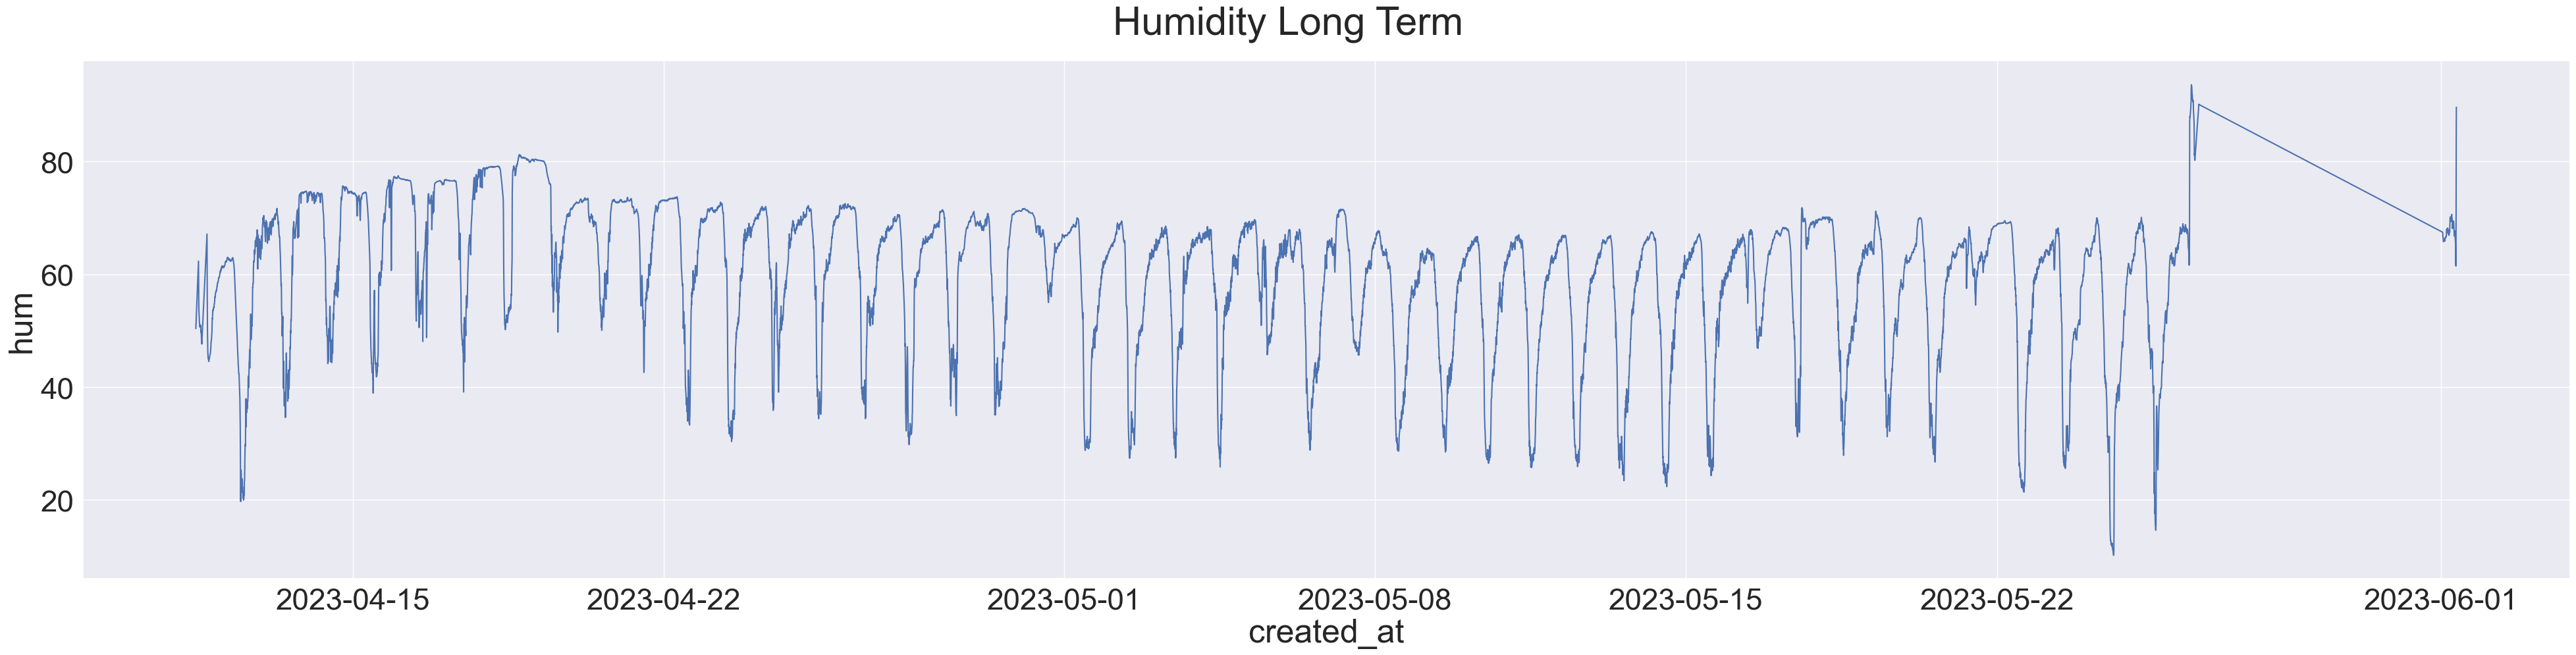

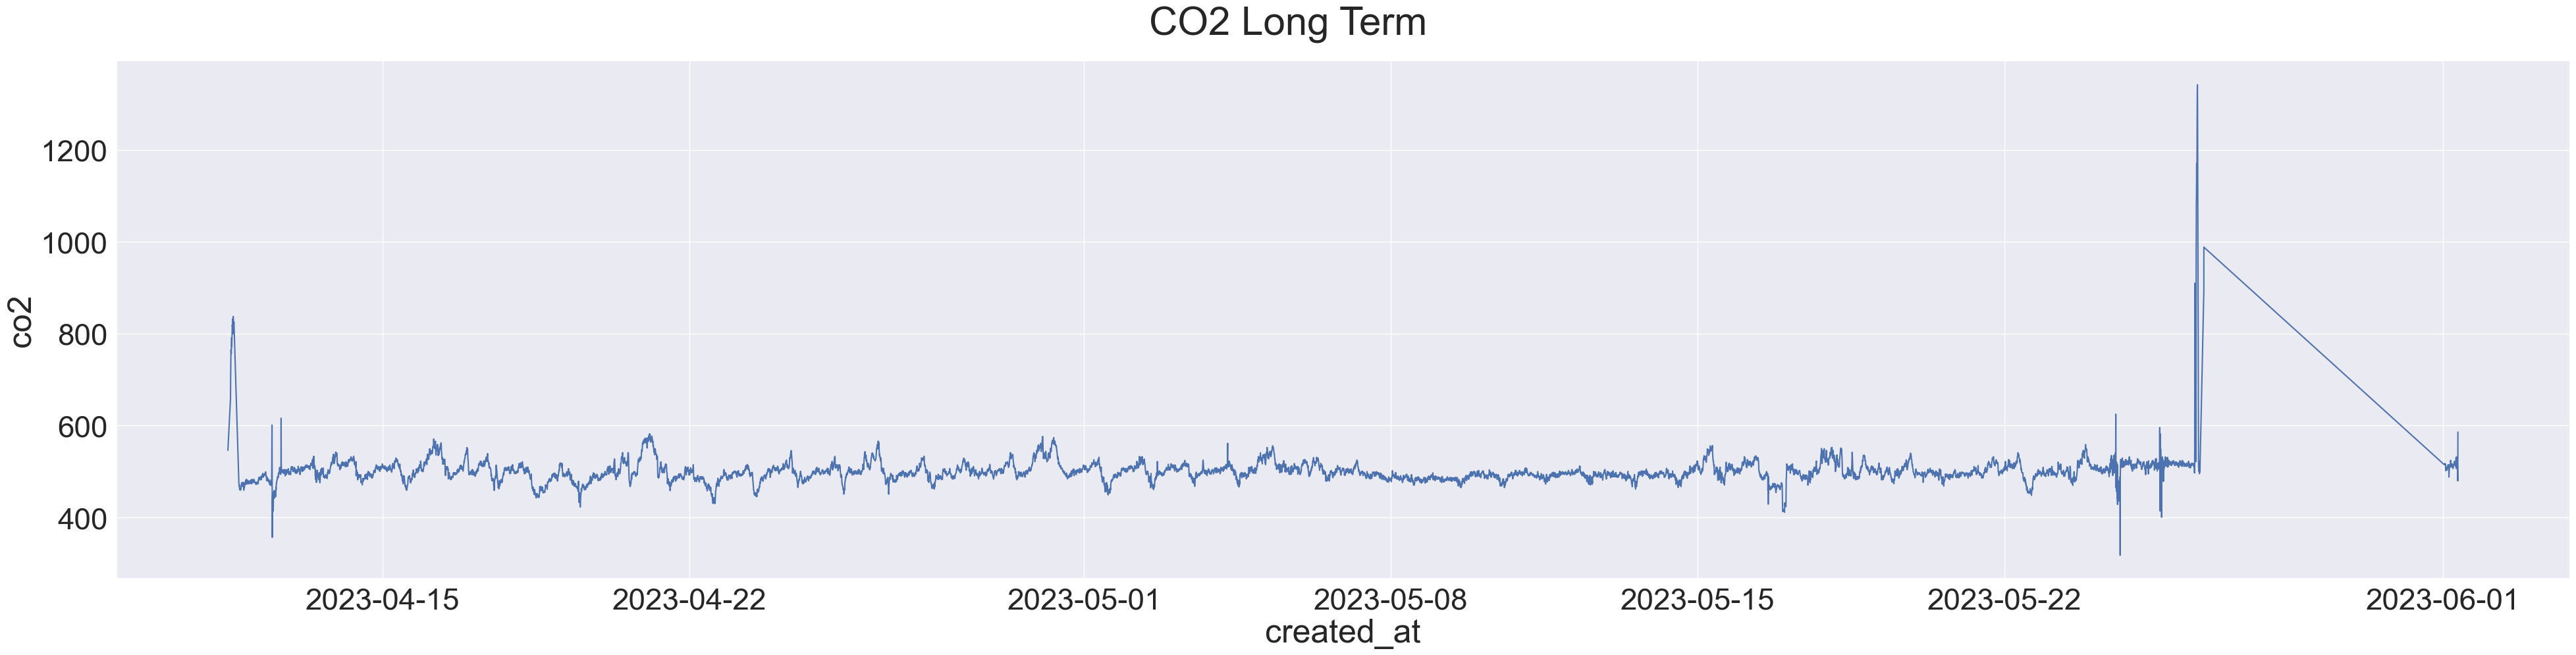

In [727]:
# Data visualisation setup
sns.set()
sns.set_theme()
sns.set(font_scale=3)

# Convert from Wide frame to Long frame for seaborn usage
long_frame = frame_final.melt(id_vars=['created_at'], value_vars=['co2', 'hum', 'temp'])

# sns.relplot(data=long_frame, x='created_at', y='value', hue='variable',
#             kind='line', height=10, aspect=4)

plot1 = sns.relplot(data=frame_final, x='created_at', y='temp',
            kind='line', height=10, aspect=4)
plot1.fig.suptitle('Temperature Long Term', y=1.03)

plot2 = sns.relplot(data=frame_final, x='created_at', y='hum',
            kind='line', height=10, aspect=4)
plot2.fig.suptitle('Humidity Long Term', y=1.03)

plot3 = sns.relplot(data=frame_final, x='created_at', y='co2',
            kind='line', height=10, aspect=4)
plot3.fig.suptitle('CO2 Long Term', y=1.03)

# long_frame

## Process 3B: Visualisation 2, Daily Trends

The following diagram plots all of the daily trends. You can change the index value to show different days.

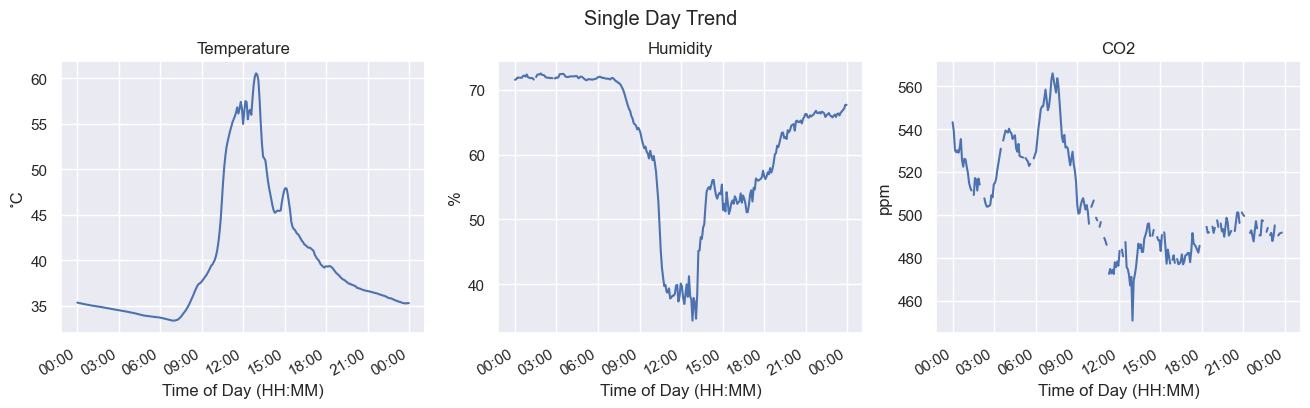

In [728]:
i = 15

sns.set(font_scale=1)
# Day by day segmentation
# Set index to sort by date
frame_flat_by_date = frame_final.set_index(['created_at']) 
# Group subdataframes by date, this produces a list of dataframes each with its own date
day_frames: list[DataFrame] = [group[1] for group in frame_flat_by_date.groupby(frame_flat_by_date.index.date)]

# Normalise to 24 hour time instead of days so we can actually plot it
time_frames: list[DataFrame] = []
for frame in day_frames:
    time_frames.append(frame.set_index(frame.index.time))

fig = plt.figure(figsize=(16,4))
axs = fig.subplots(1, 3)

my_day = datetime.date(2014, 7, 15) #HACK: use a date to convert a time object to a datetime object
current_index = [ datetime.datetime.combine(my_day, t) for t in time_frames[i].index ]

for ax in axs:
    ax.set_xlabel('Time of Day (HH:MM)')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

axs[0].set_title('Temperature')
axs[1].set_title('Humidity')
axs[2].set_title('CO2')
axs[0].set_ylabel('˚C')
axs[1].set_ylabel('%')
axs[2].set_ylabel('ppm')
fig.suptitle('Single Day Trend', y=1.01)

axs[0].plot(current_index, time_frames[i]['temp'])
axs[1].plot(current_index, time_frames[i]['hum'])
axs[2].plot(current_index, time_frames[i]['co2'])

fig.autofmt_xdate()

## Process 3C: Visualisation 3, plot daily values

Multiple passes of daily temperature, humidity and CO2 is presented in the visualisation below, and is coloured from blue to yellow based on the date for which the data is collected, from least recent to most recent.

It can be observed from this plot that there is a general trend in temperature increasing and humidity decreasing as the box is receiving more sunlight throughout the day, with few exceptions. CO2 levels remained almost entirely constant, with exceptions in certain single days (possibly due to a sensor fault).

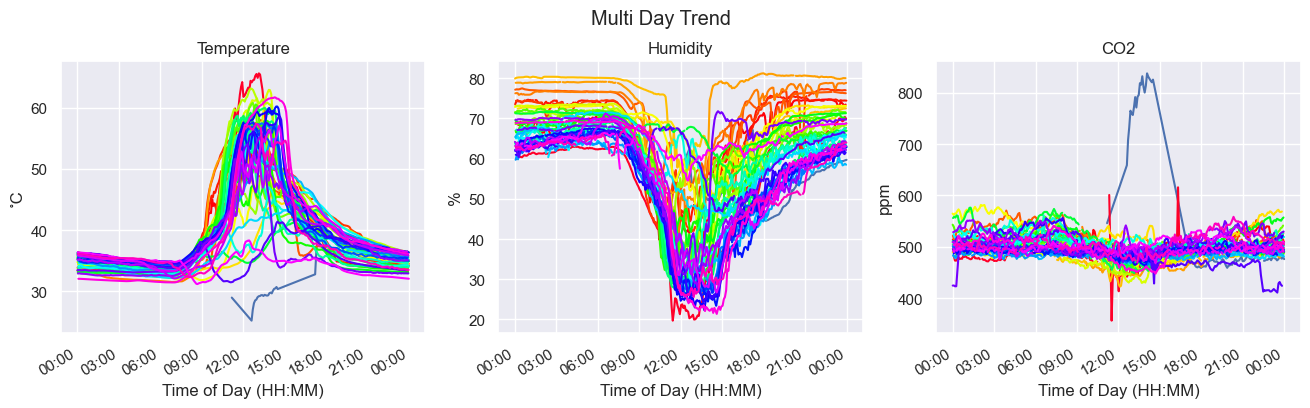

In [729]:
fig = plt.figure(figsize=(16,4))
axs = fig.subplots(1, 3)

my_day = datetime.date(2014, 7, 15) #HACK: use a date to convert a time object to a datetime object
time_frames[0].index = [ datetime.datetime.combine(my_day, t) for t in time_frames[0].index ]

for ax in axs:
    ax.set_xlabel('Time of Day (HH:MM)')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

axs[0].set_title('Temperature')
axs[1].set_title('Humidity')
axs[2].set_title('CO2')
axs[0].set_ylabel('˚C')
axs[1].set_ylabel('%')
axs[2].set_ylabel('ppm')
fig.suptitle('Multi Day Trend', y=1.01)

number=len(time_frames) - 5 #HACK: -5 is used here to account for the truncated rows at the end of the frame (time_frames[1:-4])
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, number)]

axs[0].plot(time_frames[0].index, time_frames[0]['temp'])
axs[1].plot(time_frames[0].index, time_frames[0]['hum'])
axs[2].plot(time_frames[0].index, time_frames[0]['co2'])

for idx, frame in enumerate(time_frames[1:-4]):
    frame.index = [ datetime.datetime.combine(my_day, t) for t in frame.index ]
    axs[0].plot(frame.index, frame['temp'], color=colors[idx])
    axs[1].plot(frame.index, frame['hum'], color=colors[idx])
    axs[2].plot(frame.index, frame['co2'], color=colors[idx])

fig.autofmt_xdate()